In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def create_partial_datasets(classes):
    train_data = datasets.MNIST(
        root = 'data',
        train = True,                         
        transform = ToTensor(), 
        download = True        
    )
    test_data = datasets.MNIST(
        root = 'data', 
        train = False, 
        transform = ToTensor()
    )
    
    # We need to make sure that labels always start at 0
    mapping = {old: new for new, old in enumerate(classes)}
    
    # Filter and map the training dataset
    train_idx = [i for i, label in enumerate(train_data.targets) if label in classes]
    train_data.data = train_data.data[train_idx]
    train_data.targets = torch.tensor([mapping[label.item()] for label in train_data.targets[train_idx]])
    
    # Filter and map the testing dataset
    test_idx = [i for i, label in enumerate(test_data.targets) if label in classes]
    test_data.data = test_data.data[test_idx]
    test_data.targets = torch.tensor([mapping[label.item()] for label in test_data.targets[test_idx]])
    
    return train_data, test_data

In [4]:
first_five_classes = [0, 1, 2, 3, 4]
last_five_classes = [5, 6, 7, 8, 9]

first_5_train_data, first_5_test_data = create_partial_datasets(first_five_classes)
last_5_train_data, last_5_test_data = create_partial_datasets(last_five_classes)

# MNIST train contains 60'000 images, while test contains 10'000 images
loaders = {
    'first_5_train' : torch.utils.data.DataLoader(first_5_train_data, batch_size=50, shuffle=True, num_workers=1),
    'first_5_test'  : torch.utils.data.DataLoader(first_5_test_data, batch_size=50, shuffle=True, num_workers=1),
    
    'last_5_train' : torch.utils.data.DataLoader(last_5_train_data, batch_size=50, shuffle=True, num_workers=1),
    'last_5_test'  : torch.utils.data.DataLoader(last_5_test_data, batch_size=50, shuffle=True, num_workers=1),
}

In [5]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 5 classes
        # We have 32 channels and at the beginning the image is of size 28x28, using two maxpooling operations of size 2x2
        # we get an image of size 7x7 at the end
        self.out = nn.Linear(32 * 7 * 7, 5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [9]:
def evaluate(model, test_loader):

    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [6]:
def train(num_epochs, train_loader, model, optimizer, loss_func, test_loader=None, evaluation_indices=None):
    """
    Evaluation_indices specifies the indices of the batches whenever the model should be evaluated
    """
    
    if evaluation_indices is not None:
        test_accuracies = []
        
        if test_loader is None:
            raise ValueError("test_loader cannot be None if evaluation_frequency is not None!")
    
    model.train()
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
                        
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if evaluation_indices is not None and i in evaluation_indices:
                accuracy = evaluate(model, test_loader)
                test_accuracies.append(accuracy)
            
            if evaluation_indices is not None and i >= max(evaluation_indices):
                break
    
    if evaluation_indices is not None:
        return test_accuracies

In [7]:
num_epochs = 2
num_models = 5

models = [CNN().to(device) for _ in range(num_models)]
optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]
loss_func = nn.CrossEntropyLoss()

for i, model in enumerate(models):
    print(f"Training model [{i+1}/{num_models}]")
    optimizer = optimizers[i]
    
    train(num_epochs, loaders["first_5_train"], model, optimizer, loss_func)

Training model [1/5]
Training model [2/5]
Training model [3/5]
Training model [4/5]
Training model [5/5]


In [10]:
for i, model in enumerate(models):
    acc = evaluate(model, loaders["first_5_test"])
    print(f"Testing model [{i+1}/{num_models}]: {acc}")

Testing model [1/5]: 0.9941622883829538
Testing model [2/5]: 0.9953298307063632
Testing model [3/5]: 0.9922163845106052
Testing model [4/5]: 0.9937731076084841
Testing model [5/5]: 0.9922163845106052


## Clustering

In [11]:
def calculate_cosine_similarity(cluster_group, vec):
    total_distance = 0

    for cluster_vec in cluster_group:
        
        # Reshape vectors to 2D arrays as required by cosine_similarity function
        vec1 = np.array(cluster_vec).reshape(1, -1)
        vec2 = np.array(vec).reshape(1, -1)

        # Calculate cosine similarity and convert to cosine distance
        similarity = cosine_similarity(vec1, vec2)
        distance = 1 - similarity

        # Since cosine_similarity returns a 2D array, we take the first element
        total_distance += distance[0][0]

    return total_distance

def calculate_euclidean_distance(cluster_group, vec):
    total_distance = 0

    for cluster_vec in cluster_group:
        distance = np.linalg.norm(np.array(cluster_vec) - np.array(vec))
        total_distance += distance

    return total_distance


def custom_clustering(filters_per_model, num_filters_per_model):
    filter_vectors = []
    
    num_models = len(filters_per_model)
    
    for idx, filters in enumerate(filters_per_model):
        
        filter_vectors.append([])

        for i in range(filters.shape[0]):
            # Flatten and normalize the filter
            filter_vec = filters[i].flatten()
            filter_vec /= np.linalg.norm(filter_vec)
            filter_vectors[idx].append(filter_vec)
            
    new_groups = [[] for _ in range(num_filters_per_model)]
    permutations = [[] for _ in range(num_models)]
    
    # Now we go through all models and assign filters in a greedy manner
    for i in range(num_models):
        model_filters = filter_vectors[i]
        used_indices = set()
        
        # We go through every group of the new clusters and assign the min distance vector from the next model to it
        for cluster_idx, cluster_group in enumerate(new_groups):
            min_distance = float('inf')
            selected_vector_idx = None
            
            for idx, vec in enumerate(model_filters):
                dist = calculate_cosine_similarity(cluster_group, vec)
                if dist < min_distance and idx not in used_indices:
                    min_distance = dist
                    selected_vector_idx = idx
            
            new_groups[cluster_idx].append(model_filters[selected_vector_idx])
            used_indices.add(selected_vector_idx)
            permutations[i].append(selected_vector_idx)

    return new_groups, permutations

## Permuting

In [12]:
def permute_weights(model, permutation):
    
     with torch.no_grad():
        permuted_model = copy.deepcopy(model)
        permuted_model.conv1[0].weight = torch.nn.Parameter(model.conv1[0].weight[permutation])
        permuted_model.conv1[0].bias = torch.nn.Parameter(model.conv1[0].bias[permutation])
        permuted_model.conv2[0].weight = torch.nn.Parameter(model.conv2[0].weight.transpose(0,1)[permutation].transpose(0,1))
        
        return permuted_model

In [ ]:
rand_img = torch.rand(1,1,28,28)
permutation = torch.tensor(np.random.permutation(np.linspace(0,15,16)),dtype=torch.int)

In [ ]:
model.eval()
model = CNN()
output = model(rand_img)

permuted_model = permute_weights(model, permutation)
permuted_output = permuted_model(rand_img)

out1 = model.conv1[0](rand_img)
perm_out1 = permuted_model.conv1[0](rand_img)

print(output)
print(permuted_output)

## Creating custom model

In [84]:
def cluster_second_layer_using_kmeans(num_filters, filters_per_model, num_input_channels, kernel_size):
    
    filter_vectors = []
        
    num_models = len(filters_per_model)
    
    for idx, filters in enumerate(filters_per_model):
        
        filter_vectors.append([])

        for i in range(filters.shape[0]):
            # Flatten and normalize the filter
            filter_vec = filters[i].flatten()
            filter_vec /= np.linalg.norm(filter_vec)
            filter_vectors[idx].append(filter_vec)
    
    filter_vectors = np.vstack(filter_vectors)
    kmeans = KMeans(n_clusters=num_filters, n_init='auto')
    cluster_labels = kmeans.fit_predict(filter_vectors)

    average_filters = []

    for cluster_num in range(num_filters):
        
        # Find indices where the cluster label matches the current cluster number
        indices = np.where(cluster_labels == cluster_num)[0]

        # Filters belonging to the current cluster
        cluster_filters = filter_vectors[indices]

        # Compute the average filter for this cluster
        average_filter = np.mean(cluster_filters, axis=0)
        average_filters.append(average_filter)
        
    shaped_average_filters = np.array(average_filters).reshape((num_filters, num_input_channels, kernel_size, kernel_size))
    torch_shaped_average_filters = torch.tensor(shaped_average_filters, dtype=torch.float32).to(device)
    
    return torch_shaped_average_filters

In [85]:
def cluster_single_layer(filters, num_input_channels, num_filters, kernel_size):
    
    clustered_groups, permutations = custom_clustering(filters, num_filters)
    
    filter_vectors = np.array(clustered_groups)
    average_filters = [np.mean(np.array(vectors), axis=0) for vectors in filter_vectors]
    
    shaped_average_filters = np.array(average_filters).reshape((num_filters, num_input_channels, kernel_size, kernel_size))
    torch_shaped_average_filters = torch.tensor(shaped_average_filters, dtype=torch.float32).to(device)
    
    return torch_shaped_average_filters, permutations

def permute_models(models, permutations):
    for i, (model, permutation) in enumerate(zip(models, permutations)):
        models[i] = permute_weights(model, permutation)

def create_initialized_model(models):
    final_model = CNN().to(device)
    
    trained_filters_layer1 = [model.conv1[0].weight.data.cpu().numpy() for model in models]
    sampled_filters_layer1, permutations = cluster_single_layer(trained_filters_layer1, 
                                                                num_input_channels=1, 
                                                                num_filters=16, 
                                                                kernel_size=7)
    
    permute_models(models, permutations)
    
    trained_filters_layer2 = [model.conv2[0].weight.data.cpu().numpy() for model in models]
    sampled_filters_layer2 = cluster_second_layer_using_kmeans(num_filters=32,
                                                               filters_per_model=trained_filters_layer2,
                                                               num_input_channels=16,
                                                               kernel_size=5)
    
    #sampled_filters_layer2, _ = cluster_single_layer(trained_filters_layer2,
    #                                                 num_input_channels=16,
    #                                                 num_filters=32,
    #                                                 kernel_size=5)
    

    final_model.conv1[0].weight.data = sampled_filters_layer1
    final_model.conv2[0].weight.data = sampled_filters_layer2
    
    return final_model

## Evaluation

In [86]:
def compare_models(models, loaders, num_epochs):
    final_model = create_initialized_model(models)
    random_model = CNN().to(device)
    
    final_optimizer = torch.optim.Adam(final_model.parameters(), lr=0.01)
    random_optimizer = torch.optim.Adam(random_model.parameters(), lr=0.01)
    
    loss_func = torch.nn.CrossEntropyLoss()
    
    our_accuracies = train(num_epochs, loaders["last_5_train"], final_model, final_optimizer, loss_func,
                           test_loader=loaders["last_5_test"], evaluation_indices=np.arange(25))
    
    random_accuracies = train(num_epochs, loaders["last_5_train"], random_model, random_optimizer, loss_func,
                              test_loader=loaders["last_5_test"], evaluation_indices=np.arange(25))

    return our_accuracies, random_accuracies

In [87]:
def get_average_score(num_iterations, models, loaders, plot_result=True):
    num_epochs = 1
    
    our_cumulative_accuracies = []
    random_cumulative_accuracies = []

    for i in range(num_iterations):
        our_accuracies, random_accuracies = compare_models(models, loaders, num_epochs)
        
        print(f"Our accuracies after 5 batches: {our_accuracies[5]}, after 10 batches: {our_accuracies[10]}, after 20 batches {our_accuracies[20]}")
        print(f"Final accuracies after 5 batches: {random_accuracies[5]}, after 10 batches: {random_accuracies[10]}, after 20 batches {random_accuracies[20]}")

        if not our_cumulative_accuracies:
            our_cumulative_accuracies = our_accuracies
            random_cumulative_accuracies = random_accuracies
        else:
            # Accumulate the accuracies
            our_cumulative_accuracies = [x + y for x, y in zip(our_cumulative_accuracies, our_accuracies)]
            random_cumulative_accuracies = [x + y for x, y in zip(random_cumulative_accuracies, random_accuracies)]

    # Compute the average accuracies
    our_average_accuracies = [x / num_iterations for x in our_cumulative_accuracies]
    random_average_accuracies = [x / num_iterations for x in random_cumulative_accuracies]
    
    if plot_result:
        plt.figure(figsize=(10, 6))
        plt.plot(our_average_accuracies, label='Our Model - Average Accuracy')
        plt.plot(random_average_accuracies, label='Random Model - Average Accuracy')
        plt.title('Model Comparison - Average Accuracy per Batch of image')
        plt.xlabel('Batches of images')
        plt.ylabel('Average Accuracy')
        plt.legend()
        plt.show()

Our accuracies after 5 batches: 0.8887060275663444, after 10 batches: 0.9203867516971816, after 20 batches 0.947130220119317
Final accuracies after 5 batches: 0.46492491256943014, after 10 batches: 0.5828018926146883, after 20 batches 0.8778029212096277
Our accuracies after 5 batches: 0.8259617362682575, after 10 batches: 0.9185352808064184, after 20 batches 0.947130220119317
Final accuracies after 5 batches: 0.37173421106768156, after 10 batches: 0.4974285126517178, after 20 batches 0.7848179386957416
Our accuracies after 5 batches: 0.8891174655420695, after 10 batches: 0.9055749845710759, after 20 batches 0.958856202427484
Final accuracies after 5 batches: 0.8117671261057395, after 10 batches: 0.8271960501954331, after 20 batches 0.9284097922238223
Our accuracies after 5 batches: 0.9166838099156552, after 10 batches: 0.9107179592676404, after 20 batches 0.8979633820201605
Final accuracies after 5 batches: 0.19707879037235138, after 10 batches: 0.22526229170952478, after 20 batches 0.

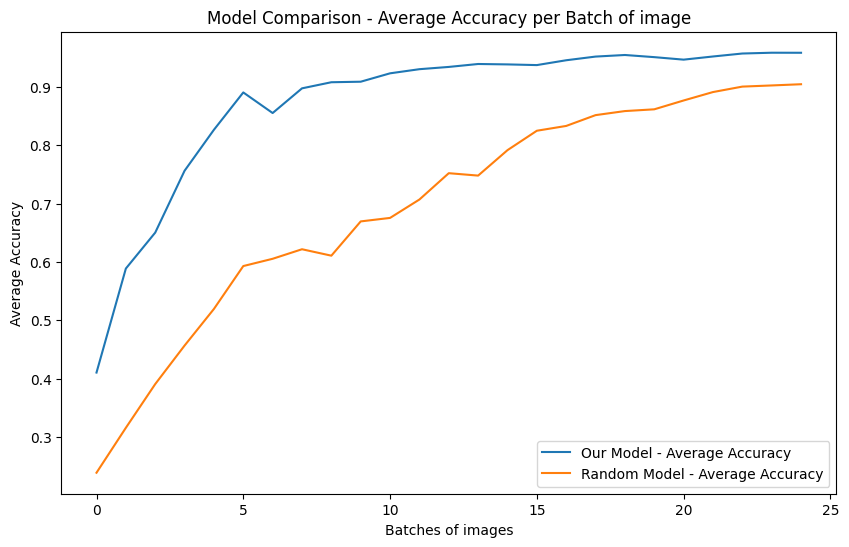

In [88]:
get_average_score(10, models, loaders)

## Visualization
Use the code below to train a model on a few images and then plot the results

In [ ]:
num_train_images = 500
use_first_half = False

In [ ]:
if use_first_half:
    visualized_train_loader = loaders['first_5_train']
    visualized_test_loader = loaders['first_5_test']
else:
    visualized_train_loader = loaders['last_5_train']
    visualized_test_loader = loaders['last_5_test']

visualized_model = models[0]
visualized_optimizer = torch.optim.Adam(visualized_model.parameters(), lr=0.01)    
visualized_loss_func = torch.nn.CrossEntropyLoss()

visualized_model.train()

images_processed = 0

for i, (images, labels) in enumerate(visualized_train_loader):

    images = images.to(device)
    labels = labels.to(device)

    output = visualized_model(images)
    loss = visualized_loss_func(output, labels)

    visualized_optimizer.zero_grad()
    loss.backward()
    visualized_optimizer.step()
    
    images_processed += len(images)
    if images_processed >= num_train_images:
        break

In [ ]:
visualized_model.eval()

# Get a batch of test images and labels
test_images, test_labels = next(iter(visualized_test_loader))

# Move the images to the same device as the model
test_images = test_images.to(device=device)

# Get predictions
with torch.no_grad():
    outputs = visualized_model(test_images)
    _, predicted = torch.max(outputs, 1)

# Convert images to numpy for visualization
# Assuming MNIST images, which are 1 channel (grayscale)
# and are 28x28 pixels
test_images = test_images.cpu().numpy()
test_images = np.squeeze(test_images)

# Plot some images with predictions
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i], cmap='gray')
    ax.set_title(f'Predicted: {predicted[i].item()}, Actual: {test_labels[i]}')
    ax.axis('off')

plt.show()